In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from math import sqrt

from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Activation, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
#Run Local
#df = pd.read_csv("csv/book_info_complete.csv")
#Run on COLAB
df = pd.read_csv("/content/drive/My Drive/final_project/book_info_complete.csv")

In [4]:
df = df.dropna(axis=1)
df["Publication date"] = df["Publication date"].str[-4:]
df = df.drop("Last updated", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             5816 non-null   object
 1   description       5816 non-null   object
 2   plot              5816 non-null   object
 3   csm_review        5816 non-null   object
 4   need_to_know      5816 non-null   object
 5   csm_rating        5816 non-null   int64 
 6   Genre             5816 non-null   object
 7   Book type         5816 non-null   object
 8   Publication date  5816 non-null   object
dtypes: int64(1), object(8)
memory usage: 409.1+ KB


In [ ]:
df["text"] = df['title'] + " " + df["Genre"] + " " + df["Book type"]+ " " + df["Publication date"]

## Create the splits

In [ ]:
def splitter(df):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=999)
    for train_index, test_index in split.split(df, df['csm_rating']):
        train_data= df.loc[train_index]
        test_data = df.loc[test_index]
    
    
    return train_data, test_data

In [ ]:
train_data, test_data = splitter(df)

In [ ]:
x_tr, y_tr = train_data['text'].values, train_data["csm_rating"].values
x_val, y_val = test_data["text"].values, test_data["csm_rating"].values

In [9]:
print(x_tr.shape, y_tr.shape)

(4652,) (4652,)


In [10]:
print(x_val.shape, y_val.shape)

(1164,) (1164,)


## Prepare the Data

In [11]:
#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_tr))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(x_tr) 
x_val_seq = tokenizer.texts_to_sequences(x_val)

print(len(max(x_tr_seq, key=len)))
max_length = len(max(x_tr_seq, key=len))
print(len(min(x_tr_seq, key=len)))

30
4


In [12]:
#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=max_length)
x_val_seq = pad_sequences(x_val_seq, maxlen=max_length)
print(len(max(x_tr_seq, key=len)))
print(len(min(x_tr_seq, key=len)))

30
30


In [13]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

5549


## Create embeddings

In [14]:
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 5548 unique tokens.


## Create the Model

In [15]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,input_length=max_length,trainable=True)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='relu')) 

#Add loss function, metrics, optimizer
#optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(optimizer="RMSprop", loss='mean_squared_error', metrics=["mae"]) 

#Print summary of model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           1664700   
_________________________________________________________________
lstm (LSTM)                  (None, 30, 128)           219648    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,892,669
Trainable params: 1,892,669
Non-trainable params: 0
_________________________________________________________________
None


## Callbacks

In [ ]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mae', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

## Fit the Model

In [17]:
history = model.fit(np.array(x_tr_seq),
                    np.array(y_tr),
                    batch_size=128,
                    epochs=1000,
                    validation_data=(np.array(x_val_seq),np.array(y_val)),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/1000
37/37 [==============================] - 1s 29ms/step - loss: 24.7253 - mae: 4.0348 - val_loss: 15.2841 - val_mae: 3.3200 - lr: 0.0010
Epoch 2/1000
37/37 [==============================] - 1s 16ms/step - loss: 14.7678 - mae: 3.2595 - val_loss: 13.5878 - val_mae: 3.1245 - lr: 0.0010
Epoch 3/1000
37/37 [==============================] - 1s 16ms/step - loss: 10.3527 - mae: 2.6895 - val_loss: 7.0825 - val_mae: 2.2592 - lr: 0.0010
Epoch 4/1000
37/37 [==============================] - 1s 15ms/step - loss: 5.3921 - mae: 1.8436 - val_loss: 4.9923 - val_mae: 1.8051 - lr: 0.0010
Epoch 5/1000
37/37 [==============================] - 1s 16ms/step - loss: 4.1883 - mae: 1.5747 - val_loss: 4.9372 - val_mae: 1.8319 - lr: 0.0010
Epoch 6/1000
36/37 [============================>.] - ETA: 0s - loss: 3.4426 - mae: 1.3988
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
37/37 [==============================] - 1s 16ms/step - loss: 3.4106 - mae: 1.3956 - val_loss:

In [18]:
#evaluation 
val_loss, val_mae = model.evaluate(x_val_seq, y_val)

print("The val_mae is %.3f." % val_mae)

37/37 [==============================] - 0s 3ms/step - loss: 5.6324 - mae: 1.7919
The val_mae is 1.792.


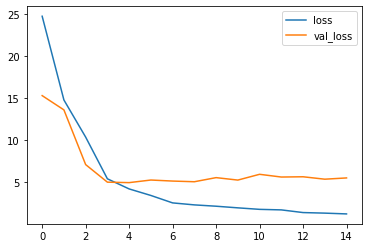

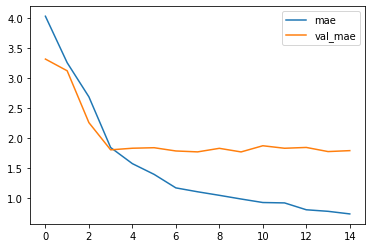

In [19]:
plt.plot(history.history["loss"], label="loss");
plt.plot(history.history["val_loss"], label="val_loss");
plt.legend();
plt.show();
plt.close();

plt.plot(history.history["mae"], label="mae");
plt.plot(history.history["val_mae"], label="val_mae");
plt.legend();

## [Use Transfer Learning](https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/)

In [20]:
# load the whole embedding into memory
embeddings_index = dict()

with open("/content/drive/My Drive/Colab Notebooks/glove.6B/glove.6B.300d.txt") as f:

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [29]:
model2=Sequential()

#embedding layer
model2.add(Embedding(size_of_vocabulary,
                    300,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False)) 

#lstm layer
model2.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model2.add(GlobalMaxPooling1D())

#Dense Layer
model2.add(Dense(64,activation='relu')) 
model2.add(Dense(1,activation='relu')) 

#Add loss function, metrics, optimizer
#optimizer = tf.keras.optimizers.RMSprop(0.001)

model2.compile(optimizer="RMSprop", loss='mean_squared_error', metrics=["mae"]) 

#Print summary of model
print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 300)           1664700   
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           219648    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,892,669
Trainable params: 227,969
Non-trainable params: 1,664,700
_________________________________________________________________
None


In [30]:
history2 = model2.fit(np.array(x_tr_seq),
                    np.array(y_tr),
                    batch_size=128,
                    epochs=1000,
                    validation_data=(np.array(x_val_seq),np.array(y_val)),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/1000
37/37 [==============================] - 1s 17ms/step - loss: 18.0535 - mae: 3.3394 - val_loss: 6.5507 - val_mae: 2.0037 - lr: 0.0010
Epoch 2/1000
37/37 [==============================] - 0s 9ms/step - loss: 5.9946 - mae: 1.9540 - val_loss: 5.1979 - val_mae: 1.7876 - lr: 0.0010
Epoch 3/1000
37/37 [==============================] - 0s 8ms/step - loss: 5.6456 - mae: 1.8716 - val_loss: 6.0998 - val_mae: 1.9497 - lr: 0.0010
Epoch 4/1000
32/37 [========================>.....] - ETA: 0s - loss: 5.2239 - mae: 1.7945
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
37/37 [==============================] - 0s 8ms/step - loss: 5.2588 - mae: 1.7995 - val_loss: 5.1548 - val_mae: 1.7947 - lr: 0.0010
Epoch 5/1000
37/37 [==============================] - 0s 8ms/step - loss: 4.6829 - mae: 1.6864 - val_loss: 4.7246 - val_mae: 1.7200 - lr: 5.0000e-04
Epoch 6/1000
37/37 [==============================] - 0s 8ms/step - loss: 4.4742 - mae: 1.6429 - val_loss: 4.60

In [31]:
#evaluation 
_, val_mae = model2.evaluate(x_val_seq, y_val)

print("The val_mae is %.3f." % val_mae)

37/37 [==============================] - 0s 3ms/step - loss: 4.5918 - mae: 1.6565
The val_mae is 1.657.


In [32]:
model2.save('/content/drive/My Drive/final_project/lstm_title')

INFO:tensorflow:Assets written to: /content/drive/My Drive/final_project/lstm_title/assets


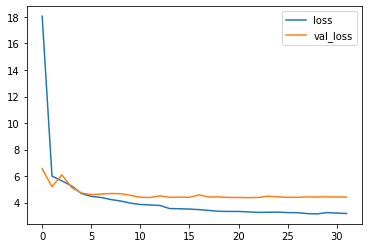

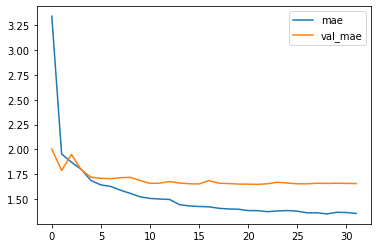

In [33]:
plt.plot(history2.history["loss"], label="loss");
plt.plot(history2.history["val_loss"], label="val_loss");
plt.legend();
plt.show();
plt.close();

plt.plot(history2.history["mae"], label="mae");
plt.plot(history2.history["val_mae"], label="val_mae");
plt.legend();

In [ ]:
a = model2.predict(x_val_seq)
b = model2.predict(x_val_seq)

predictions_df = pd.DataFrame({"title_custom": list(a), "title_transfer": list(b)},
                              columns = ["title_custom", "title_transfer"], 
                              index=test_data.index)

predictions_df.to_csv('/content/drive/My Drive/final_project/lstm_title.csv', index="False")
